In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_edges = pd.read_csv('../data/csv/edges_deep_link_no_merge.csv')
df_edges['time'] = df_edges['time'] = pd.to_datetime(df_edges['time'], unit='s')
df_edges = df_edges[df_edges['time']> '2022-05-01']
df_edges['time'] = df_edges['time'].dt.date
df_edges.sort_values(by='time', ascending=False)

,source,target,score,weight,time,sub
59283,Complex_Doubt1,JT_1976,1,0.50,2022-05-16,Ethereum
59282,Complex_Doubt1,JT_1976,1,1.00,2022-05-16,Ethereum
59284,Complex_Doubt1,JT_1976,1,0.25,2022-05-16,Ethereum
34167,BigPlayCrypto,Deep-Art3195,2,2.00,2022-05-15,Bitcoin
34168,Beatnik77,Deep-Art3195,1,1.00,2022-05-15,Bitcoin
...,...,...,...,...,...,...
45137,soggypoopsock,Cryptogrannie,20,20.00,2022-05-01,Bitcoin
45138,soggypoopsock,AutisticMortymer,20,10.00,2022-05-01,Bitcoin
45142,peterisnothere,blopblipbloup,12,12.00,2022-05-01,Bitcoin
45143,peterisnothere,Cryptogrannie,12,12.00,2022-05-01,Bitcoin


In [3]:
G = nx.from_pandas_edgelist(df_edges, create_using=nx.MultiDiGraph())

In [4]:
layout = nx.spring_layout(G, seed=500, iterations=100)

In [5]:
nx_ranks = nx.pagerank(G)

In [6]:
def page_rank(G: nx.digraph, iterations=100, alpha=0.85, error=1.0e-6):
    if len(G)==0: return {}
    nodes = list(G)
    A = nx.to_numpy_array(G, nodelist=nodes, weight="weight", dtype=float)
    n, m = A.shape
    if n==0: return {}
    S = A.sum(axis=1)
    S[S != 0] = 1.0 / S[S != 0]
    Q = np.zeros((n,m))
    np.fill_diagonal(Q, S.T.flatten())
    A = Q.dot(A)
    x = np.ones(n)/n
    p = np.ones(n)/n
    for _ in range(iterations):
        xlast = x
        x = alpha * (x.dot(A) + sum(x[np.where(S == 0)[0]]) * p) + (1 - alpha) * p
        err = np.absolute(x - xlast).sum()
        if err < n * error:
            return dict(zip(nodes, map(float, x)))
    return dict(zip(nodes,map(float,x)))

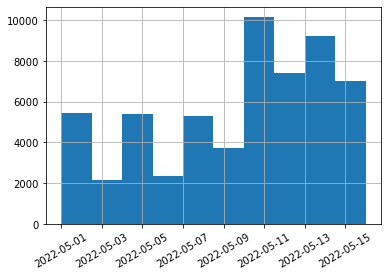

In [32]:
df_edges['time'].hist(bins=10, xrot=30)
plt.savefig('../data/images/comments_repartition.pdf')

In [8]:
df_edges

,source,target,score,weight,time,sub
0,amorydmart,Stevenlerma10,51,51.0,2022-05-15,Dogecoin
1,azn1217,Stevenlerma10,9,9.0,2022-05-15,Dogecoin
2,azn1217,amorydmart,9,9.0,2022-05-15,Dogecoin
3,DanAlucard,Stevenlerma10,9,9.0,2022-05-15,Dogecoin
4,DanAlucard,amorydmart,9,9.0,2022-05-15,Dogecoin
...,...,...,...,...,...,...
104966,explorer-9,electricmaster23,5,5.0,2022-05-15,Bitcoin
104973,geogrant1000,Michellerose6834,3,3.0,2022-05-04,CryptoCurrencies
104974,BasicallyTony,Michellerose6834,3,3.0,2022-05-04,CryptoCurrencies
104975,BasicallyTony,geogrant1000,3,3.0,2022-05-04,CryptoCurrencies


In [21]:
days = df_edges.groupby('time').groups
days = np.array(list(days.keys()))[:-1]
graphs = [nx.from_pandas_edgelist(df_edges[df_edges['time']==day], create_using=nx.MultiDiGraph) for day in days]
ranks = [nx.pagerank(g) for g in graphs]   

In [22]:
first = graphs[0]
first_rank = ranks[0]
v = np.array(list(first_rank.values()))
first_node_sizes = (v - v.min()) / (v.max() - v.min())

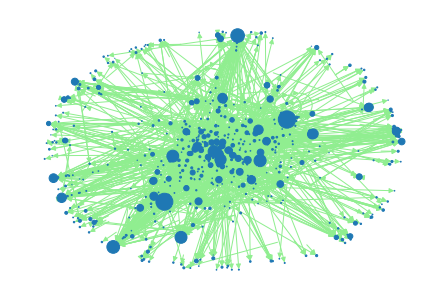

In [23]:
nx.draw(first, pos=layout, node_size=first_node_sizes*300, edge_color='lightgreen')

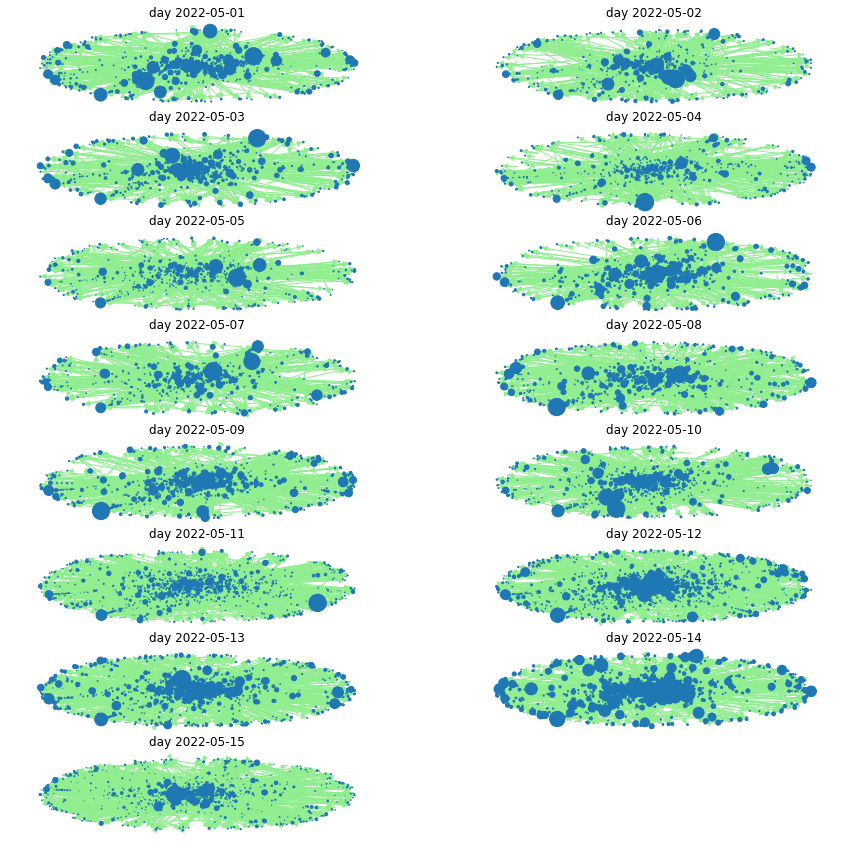

In [30]:
rows, columns = len(graphs)//2+1, 2
fig, axs = plt.subplots(rows, columns, figsize=(15,15))
axs = axs.flatten()
[ax.axis('off') for ax in axs]
for i, graph in enumerate(graphs):
    r = np.array(list(ranks[i].values()))
    r = (r - r.min()) / (r.max() - r.min())
    ax=axs[i]
    nx.draw(graph, pos=layout, node_size=r*300, edge_color='lightgreen', ax=ax)
    ax.set_title(f"day {days[i]}")

In [31]:
fig.savefig('../data/images/nx_rep_days.pdf')